# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

## Import packages

In [1]:
from IPython.display import display, HTML   
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

## Data split
Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution 

Graph the distribution of classes for each user

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
total_tr_len = len(cifar10_train)

X={}
Y=[]
for i in range(len(cifar10_train)):
    data = cifar10_train[i][0].numpy()
    label = cifar10_train[i][1]

    if label in X:
        X[label].append(data)
    else:
        X[label] = []
        X[label].append(data)
        Y.append(label)

for label in X:
    X[label] = np.array(X[label])
Y=np.array(Y)

alpha = 1
n_users = 50

In [5]:
user_train_data_non_tensors = [[] for _ in range(n_users)]
user_train_label_non_tensors = [[] for _ in range(n_users)]

for label in Y:
    alpha_list = [alpha for _ in range(n_users)]
    probs = np.random.dirichlet(alpha_list)

    taken_index = 0

    for i, prob in enumerate(probs):
        if i == n_users - 1:
            user_train_data_non_tensors[i].extend(X[label][taken_index:])
            user_train_label_non_tensors[i].extend([label for _ in range(len(X[label]) - taken_index)])
        else:
            n_sample = math.floor(prob * len(X[label]))

            user_train_data_non_tensors[i].extend(X[label][taken_index : taken_index + n_sample])
            user_train_label_non_tensors[i].extend([label for _ in range(n_sample)])
            taken_index += n_sample

user_train_data_tensors = []
user_train_label_tensors = []

user_tr_len = []

for i in range(n_users):

    if len(user_train_data_non_tensors[i]) != len(user_train_label_non_tensors[i]):
        sys.exit(f"Shape does not match user_train_data_non_tensors[i] hsa {len(user_train_data_non_tensors[i])}, while user_train_label_non_tensors[i] has {len(user_train_label_non_tensors[i])}")
   
    
    num_data = len(user_train_data_non_tensors[i])
    user_tr_len.append(num_data)

    user_train_data_tensors.append(torch.from_numpy(np.array(user_train_data_non_tensors[i])).type(torch.FloatTensor))
    user_train_label_tensors.append(torch.from_numpy(np.array(user_train_label_non_tensors[i])).type(torch.LongTensor))

    r=np.arange(num_data)
    
    np.random.shuffle(r)    

    user_train_data_tensors[i] = user_train_data_tensors[i][r]
    user_train_label_tensors[i] = user_train_label_tensors[i][r]

    print(f'user {i} has {user_train_data_tensors[i].shape[0]} train data, and {user_train_label_tensors[i].shape[0]} train labels')
    


user 0 has 1014 train data, and 1014 train labels
user 1 has 622 train data, and 622 train labels
user 2 has 859 train data, and 859 train labels
user 3 has 934 train data, and 934 train labels
user 4 has 1923 train data, and 1923 train labels
user 5 has 1190 train data, and 1190 train labels
user 6 has 969 train data, and 969 train labels
user 7 has 1011 train data, and 1011 train labels
user 8 has 757 train data, and 757 train labels
user 9 has 890 train data, and 890 train labels
user 10 has 1197 train data, and 1197 train labels
user 11 has 1434 train data, and 1434 train labels
user 12 has 1540 train data, and 1540 train labels
user 13 has 794 train data, and 794 train labels
user 14 has 1061 train data, and 1061 train labels
user 15 has 1465 train data, and 1465 train labels
user 16 has 1126 train data, and 1126 train labels
user 17 has 1134 train data, and 1134 train labels
user 18 has 1163 train data, and 1163 train labels
user 19 has 874 train data, and 874 train labels
user 2

In [6]:
X2 = []
Y2 = []

for i in range(len(cifar10_test)):
    X2.append(cifar10_test[i][0].numpy())
    Y2.append(cifar10_test[i][1])

X2=np.array(X2)
Y2=np.array(Y2)

half_index = len(X2) // 2

val_data= X2[:half_index]
val_label= Y2[:half_index]

te_data=X2[half_index:]
te_label=Y2[half_index:]

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

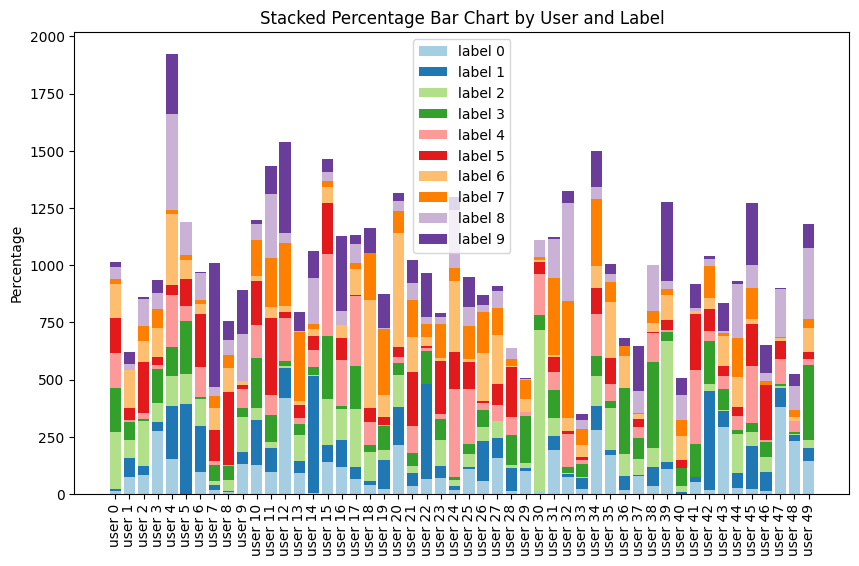

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example data
users = [f"user {i}" for i in range(50)]
labels = [f"label {i}" for i in range(10)]


percentages = []
for user_data in user_train_label_non_tensors:
    temp_holder = []
    for label in range(10):
        temp_holder.append(user_data.count(label))
    percentages.append(temp_holder)

percentages = np.array(percentages)

# Assuming 'percentages' is populated correctly as shown previously
# Convert percentages to cumulative sum for stacking
cumulative = np.cumsum(percentages, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each ethnicity, ensuring there are enough colors for all labels
colors = plt.cm.Paired(range(len(labels))) # Repeating colors to match the number of labels

# Create stacked bars
for i in range(len(labels)):  # Iterate over the number of labels
    if i == 0:
        ax.bar(users, percentages[:, i], color=colors[i], label=labels[i])
    else:
        ax.bar(users, percentages[:, i], bottom=cumulative[:, i-1], color=colors[i], label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Stacked Percentage Bar Chart by User and Label')
ax.set_xticks(np.arange(len(users)))
ax.set_xticklabels(users, rotation=90)  # Rotate labels if needed
ax.legend()


plt.savefig('./non_iid_user_label_distribution.png', bbox_inches='tight')
plt.show()


## Our Aggregation Function

In [8]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    # find the index of 10 users to be discarded
    discarded_history = []
    for _ in range(n_attackers):
        sum_of_distances = []
        for i, row in enumerate(history_updates):
            if i in discarded_history:
                sum_of_distances.append(-1)
                continue
            distance_sum = 0
            for j, other_row in enumerate(history_updates): 
                if row != other_row and j not in discarded_history: 
                    distance_sum += euclidean_distance(row, other_row)
            sum_of_distances.append(distance_sum)
        max_distance = max(sum_of_distances) 
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)
    
    # get tensors in all_updates excluding the discarded ones
    mask = torch.ones(all_updates.size(0), dtype=torch.bool)  # Create a mask of ones (True)
    mask[discarded_history] = False  # Set indices in discarded_history to False
    remaining_updates = all_updates[mask]

    print('discarded index', discarded_history)

    # returns the mean of selected updates 
    # after changing the attack, it should not have nan values
    return torch.nanmean(remaining_updates, dim=0)
    

def euclidean_distance(row1, row2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(row1, row2)))


## Code for no defense aggregation algorithm

In [9]:
def no_defense_aggregation(user_grads):
    return torch.nanmean(user_grads, dim=0)

## our_attack_mean
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}|$

In [67]:
def our_attack_mean(all_updates, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):

    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = [] 
    attacker_grads = all_updates[:n_attacker]


    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_train_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_train_label_tensors[index].cuda()

        def rosen(X):
            lambda1 = X[1].item()
            X = X[0].cuda()
            attacker_abs_mean = X.abs().mean()
            # Reshape X into the shape of fed_model.parameters
            
            fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
            optimizer_fed = SGD(fed_model.parameters(), lr=0.001)

            optimizer_fed.zero_grad()
            model_grads=[]
            start_idx = 0
            for _, param in enumerate(fed_model.parameters()):
                param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
                start_idx=start_idx+len(param.data.view(-1))
                param_=param_.cuda()
                model_grads.append(param_)
            optimizer_fed.step(model_grads)
            
            # loss = criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor)
            # mean_difference = torch.abs(benign_abs_mean_avg - attacker_abs_mean)
            # lambda1 = math.pow(10, -loss/mean_difference // 10)

            # return -loss + lambda1 * mean_difference
            return -criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor) + lambda1 * torch.abs(benign_abs_mean_avg - attacker_abs_mean)
        
        from torchmin import minimize_constr
        # res = minimize(
        #     rosen, attacker_grad, 
        #     method='l-bfgs', 
        #     options=dict(line_search='strong-wolfe'),
        #     max_iter=1,
        #     disp=False
        # )

        res = minimize_constr(
            rosen,
            torch.cat((attacker_grad, torch.tensor([100]).cuda()), 0.item()),
            max_iter=100,
            constr=dict(
                fun=lambda x: x[1].item(), 
                lb=1, ub=1
            ),
            disp=1
        )
        
        result_attacker_grads.append(res.grad)

    return torch.stack(result_attacker_grads).cuda()

## Set number of epochs

In [11]:
nepochs= 10

## Execute our attack + 10 attacker + our defense

In [12]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)
        
        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
        
        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)
        
        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads
        
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])        

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

c:\Users\Hizan\Desktop\CPEN497-FL\CPEN497-499\sgd.py:109: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1630.)
  p.data.add_(-group['lr'], d_p)


discarded index [1, 7, 6, 8, 9, 0, 5, 2, 4, 3]
epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3026 val acc 9.8011 best val_acc 9.801136


C:\Users\Hizan\AppData\Local\Temp\ipykernel_11132\1635709870.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index [7, 1, 0, 8, 9, 6, 4, 2, 5, 3]
epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3021 val acc 9.8011 best val_acc 9.801136
discarded index [7, 1, 0, 8, 9, 6, 4, 2, 5, 3]
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3016 val acc 9.8011 best val_acc 9.801136
discarded index [30, 7, 1, 0, 8, 9, 6, 4, 2, 5]
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3012 val acc 9.8011 best val_acc 9.801136
discarded index [30, 7, 1, 0, 8, 9, 6, 2, 4, 5]
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3007 val acc 13.8393 best val_acc 13.839286
discarded index [30, 7, 1, 0, 8, 6, 9, 4, 2, 5]
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.3003 val acc 14.9554 best val_acc 14.955357
discarded index [30, 7, 1, 0, 8, 6, 4, 9, 2, 5]
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.2998 val acc 13.5958 best val_acc 14.955357
discarded index [30, 7, 1, 0, 8, 6, 9, 2, 4, 5]
epoch: 7, bulyan: at our-agr n_at 10 e 7 | val loss 2.2993 val acc 13.5755 best val_

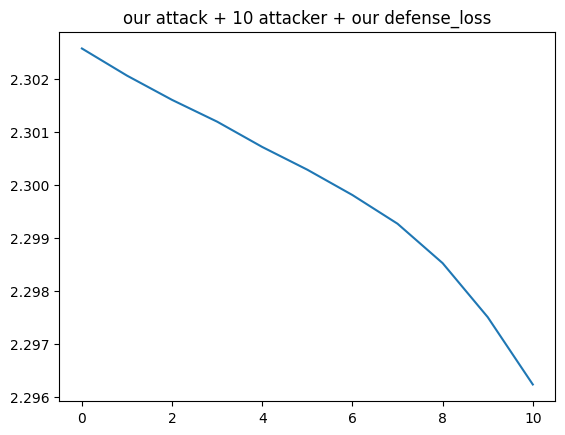

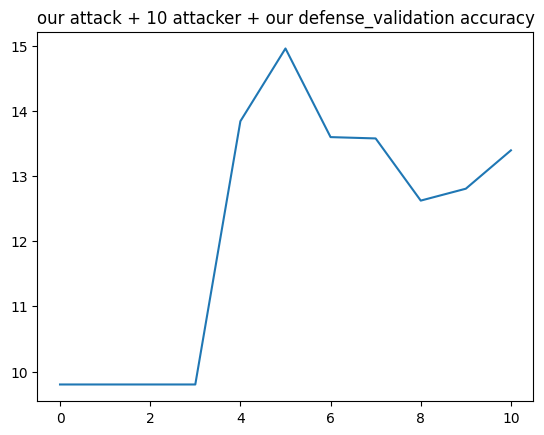

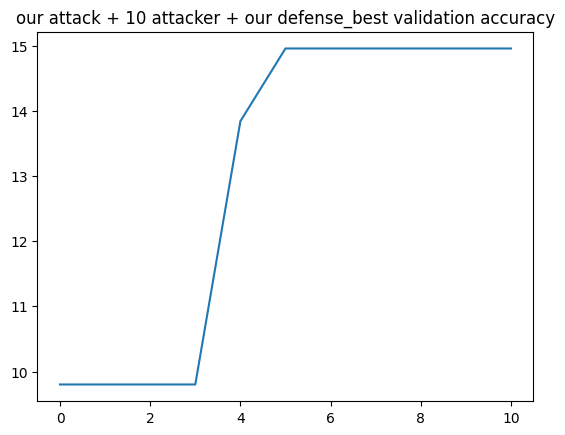

In [13]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 10 attacker + our defense ' + col + '.png')
    plt.show()

## Execute no attack + our defense

In [14]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[0]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad ()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
       
        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:  
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])        

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no attack + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

discarded index []
epoch: 0, bulyan: at our-agr n_at 0 e 0 | val loss 2.3025 val acc 10.5925 best val_acc 10.592532


C:\Users\Hizan\AppData\Local\Temp\ipykernel_11132\1124658370.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index []
epoch: 1, bulyan: at our-agr n_at 0 e 1 | val loss 2.3020 val acc 10.0446 best val_acc 10.592532
discarded index []
epoch: 2, bulyan: at our-agr n_at 0 e 2 | val loss 2.3016 val acc 9.9635 best val_acc 10.592532
discarded index []
epoch: 3, bulyan: at our-agr n_at 0 e 3 | val loss 2.3011 val acc 9.8011 best val_acc 10.592532
discarded index []
epoch: 4, bulyan: at our-agr n_at 0 e 4 | val loss 2.3006 val acc 9.8214 best val_acc 10.592532
discarded index []
epoch: 5, bulyan: at our-agr n_at 0 e 5 | val loss 2.3000 val acc 9.8011 best val_acc 10.592532
discarded index []
epoch: 6, bulyan: at our-agr n_at 0 e 6 | val loss 2.2994 val acc 9.8214 best val_acc 10.592532
discarded index []
epoch: 7, bulyan: at our-agr n_at 0 e 7 | val loss 2.2987 val acc 9.8011 best val_acc 10.592532
discarded index []
epoch: 8, bulyan: at our-agr n_at 0 e 8 | val loss 2.2979 val acc 9.8011 best val_acc 10.592532
discarded index []
epoch: 9, bulyan: at our-agr n_at 0 e 9 | val loss 2.2968 va

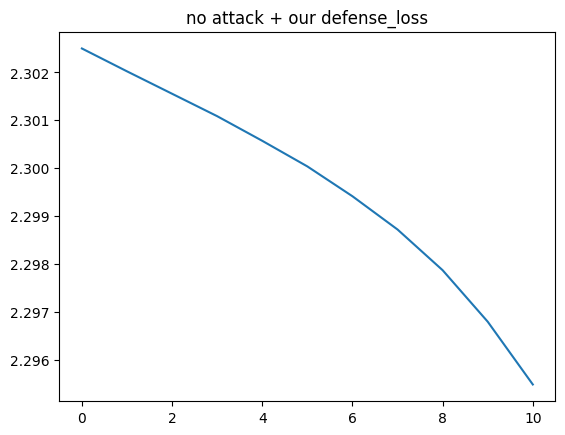

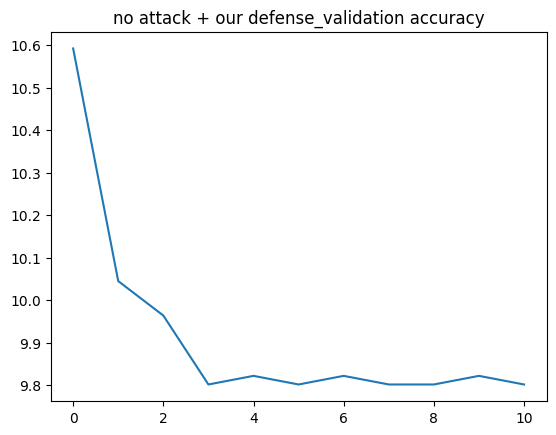

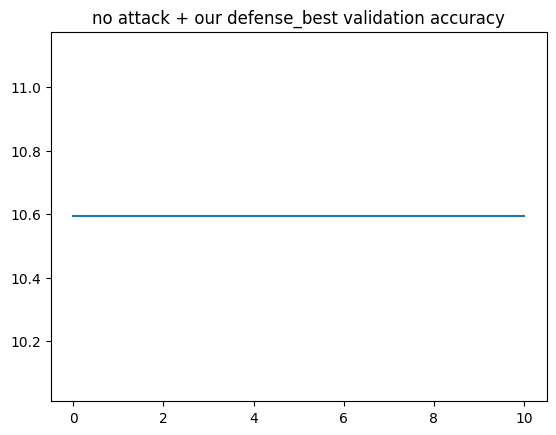

In [15]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("no attack + our defense_"+col)
    plt.savefig('./no attack + our defense ' + col + '.png')
    plt.show()

## Execute our attack + 10 attacker + no defense (take mean of all user gradients)

In [68]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
       
        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:  
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        print(updates_abs_mean)
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i].cpu())        
 
        agg_grads = no_defense_aggregation(malicious_grads)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + no defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


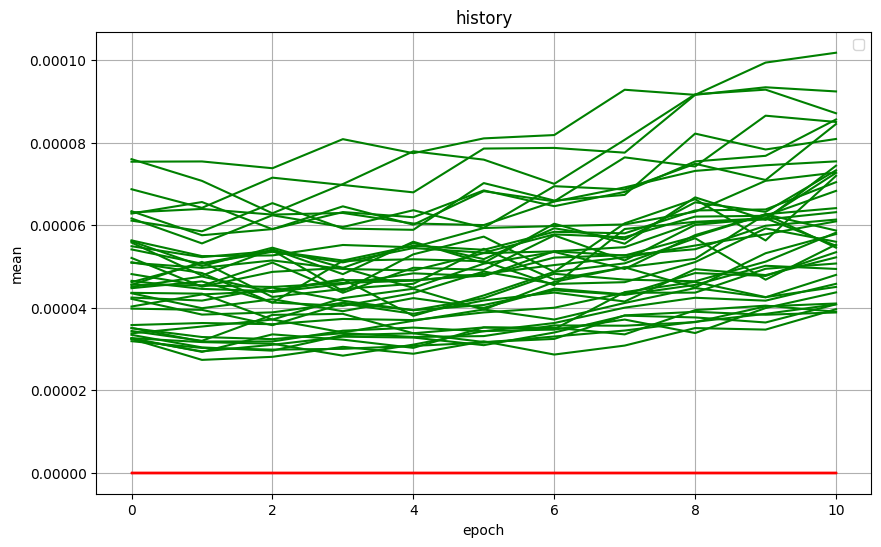

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ne = 11

plt.figure(figsize=(10, 6))
x = np.arange(11)

for i in range(10):
    y = history[i]
    plt.plot(x, y, color='red')

for i in range(40):
    y = history[i+10]
    plt.plot(x, y, color='green')
    
plt.title('history')
plt.xlabel('epoch')
plt.ylabel('mean')
plt.legend()
plt.grid(True)
plt.show()

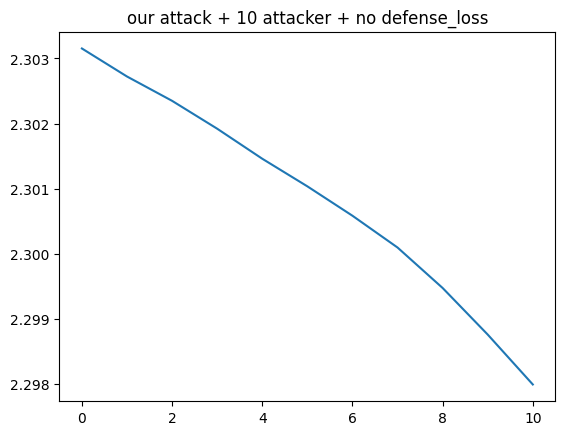

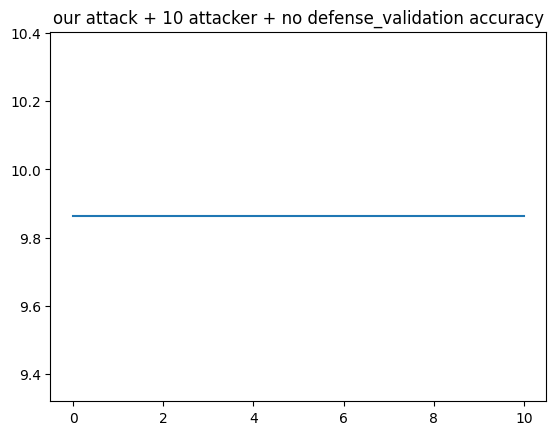

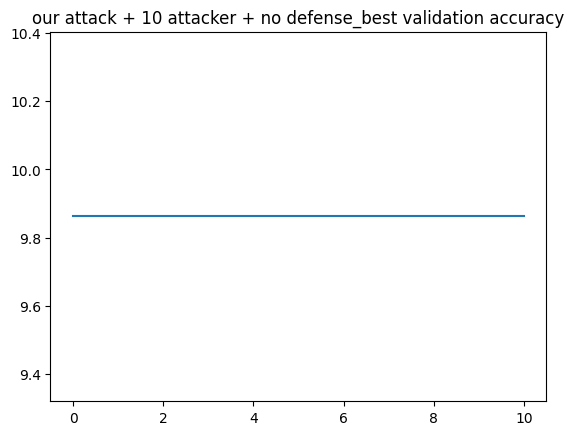

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + no defense_"+col)
    plt.savefig('./our attack + 10 attacker + no defense ' + col + '.png')
    plt.show()